# Title
## Subtitle
---
<b>MADS-EMDM Portfolio-Exam Part 2<br>
Janosch Höfer, 938969</b>

## Table of contents

- [Introduction](#intro) <br>
- [1. Data Exploration](#data-prep) <br>
    - [1.1. Data Engineering](#dataeng) <br>
    - [1.2. Data Visualization](#datavis) <br>
    - [1.3. Graphs](#graphs) <br>
- [2. Experiments](#exp) <br>
   - [2.1. Node-Roles](#noderoles) <br>
   - [2.2. Community-Discovery](#comdis)<br>
- [3. Results](#results)<br>
- [References](#ref)<br>

## Introduction

In [1]:
# Standard libraries
import os
import json

import mplcyberpunk
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
# Own classes and functions
from helper_scripts.draw_graph import prepare_drawing, draw_graph_filtered

In [2]:
pd.set_option("display.max_columns", 25)

Motivation

---
<a id='data-prep'></a>

## 1. Data Exploration
<a id='dataeng'></a>
### 1.1. Data Engineering

The dataset used for this analysis is called IMDB Films By Actor For 10k Actors and can be found on Kaggle [[1]](https://www.kaggle.com/datasets/darinhawley/imdb-films-by-actor-for-10k-actors). The license of the dataset is CC0 and therefore dedicated to the public domain.


In [3]:
path_to_data = "data"

In [4]:
df = pd.read_csv(os.path.join(path_to_data, "actorfilms.csv"))

In [5]:
df.head()

,Actor,ActorID,Film,Year,Votes,Rating,FilmID
0,Fred Astaire,nm0000001,Ghost Story,1981,7731,6.3,tt0082449
1,Fred Astaire,nm0000001,The Purple Taxi,1977,533,6.6,tt0076851
2,Fred Astaire,nm0000001,The Amazing Dobermans,1976,369,5.3,tt0074130
3,Fred Astaire,nm0000001,The Towering Inferno,1974,39888,7.0,tt0072308
4,Fred Astaire,nm0000001,Midas Run,1969,123,4.8,tt0064664


The dataset contains the IMBD ratings for the movies that the ~10.000 actors have starred in. Besides the actor's and Movie name it contains the year the movie was released, the number of IMDB ratings, the average IMDB rating and IDs for the actor and movie. Because the IDs are not needed they are dropped.

In [6]:
df = df.drop(columns=["ActorID", "FilmID"])
df.duplicated().sum()

0

After we drop the ID columns, we make sure that we have not created any duplicates.

In [7]:
df.shape

(191873, 5)

The dataset has 191,873 entries.

In [8]:
print(f"Unique actors: {len(df['Actor'].unique()):,d} \nUnique movies: {len(df['Film'].unique()):,d}")

Unique actors: 9,615 
Unique movies: 41,050


The dataset contains 9,615 unique actors and 41,050 unique movies.

In [9]:
df.describe()

,Year,Votes,Rating
count,191873.000000,1.918730e+05,191873.000000
mean,1997.952948,5.041857e+04,5.975764
std,19.839797,1.392857e+05,1.094434
min,1914.000000,1.000000e+02,1.000000
25%,1990.000000,6.690000e+02,5.400000
50%,2004.000000,3.906000e+03,6.100000
75%,2013.000000,3.213200e+04,6.700000
max,2021.000000,2.371548e+06,9.300000


The oldest movie is from 1914 and the newest is from 2021. The lowest rating is 1.0 and the highest rating 9.3.

The number of votes goes from 100 to 2,371,548, with 75% of all movies having less than 33,000 votes.

In [10]:
df_movies = df.groupby("Film")[["Year", "Votes", "Rating"]].max().reset_index()

In [11]:
df_movies.loc[df_movies["Votes"].nlargest(10).index]

,Film,Year,Votes,Rating
35821,The Shawshank Redemption,1994,2371548,9.3
31364,The Dark Knight,2008,2335143,9.0
15646,Inception,2010,2094535,8.8
11284,Fight Club,1999,1876882,8.8
24467,Pulp Fiction,1994,1847827,8.9
11866,Forrest Gump,1994,1833787,8.8
34200,The Matrix,1999,1696491,8.7
33868,The Lord of the Rings: The Fellowship of the Ring,2001,1680215,8.8
33869,The Lord of the Rings: The Return of the King,2003,1660358,8.9
32408,The Godfather,1972,1642278,9.2


The ten Movies with the most ratings are most often released in the 90s and early 2000s. The Godfather (1972), The Dark Knight (2008) and Inception (2010) are the exception.

In [12]:
df_movies.loc[df_movies["Rating"].nlargest(10).index]

,Film,Year,Votes,Rating
35821,The Shawshank Redemption,1994,2371548,9.3
32408,The Godfather,1972,1642278,9.2
33679,The Lehman Trilogy,2019,164,9.2
4137,Behind the Album: The Performances,2017,199,9.1
21604,National Theatre Live: Angels in America Part ...,2017,378,9.1
123,12 Angry Men,1957,699843,9.0
24780,Ramayana: The Legend of Prince Rama,1992,2356,9.0
31283,The Crucible,2014,35536,9.0
31364,The Dark Knight,2008,2335143,9.0
32410,The Godfather: Part II,1974,1143820,9.0


The ten Movies with the highest ratings show how a good rating can be misleading. Just because a movie has 9+ rating, it does not mean that it is a popular or good movie. It most likely is niche film with dedicated fans. In order to filter those niche movies and also decrease the size of the dataset we will remove movies with not enough ratings.

In [13]:
votes_threshold = 100_000
df_movies_pop = df_movies.loc[df_movies["Votes"] >= votes_threshold].copy()
df_movies_flop = df_movies.loc[df_movies["Votes"] < votes_threshold].copy()
df_movies_pop.shape, df_movies_flop.shape

((1905, 4), (39145, 4))

Using 100,000 as the threshold this brings the number of movies from 41,050 down to 1,905.

Applying that to the full dataset reduces the number of entries from 191,873 to 76,995 entries.

In [14]:
df_pop = df[df["Film"].isin(df_movies_pop["Film"].tolist())]
df_pop.shape

(26126, 5)

In [15]:
df_pop[df_pop["Actor"] == "Tom Hanks"].nlargest(10, "Rating")

,Actor,Film,Year,Votes,Rating
6686,Tom Hanks,Forrest Gump,1994,1833787,8.8
6679,Tom Hanks,The Green Mile,1999,1163069,8.6
6681,Tom Hanks,Saving Private Ryan,1998,1249995,8.6
6684,Tom Hanks,Toy Story,1995,897495,8.3
6665,Tom Hanks,Toy Story 3,2010,764545,8.2
6676,Tom Hanks,Catch Me If You Can,2002,846690,8.1
6680,Tom Hanks,Toy Story 2,1999,532307,7.9
6651,Tom Hanks,Toy Story 4,2019,208751,7.8
6660,Tom Hanks,Captain Phillips,2013,425345,7.8
6678,Tom Hanks,Cast Away,2000,530674,7.8


<a id='datavis'></a>
### 1.2. Data Visualization 

In [16]:
df_movies_flop["Movie Type"] = "All"
df_movies_pop["Movie Type"] = "Popular"
df_movies_all = pd.concat([df_movies_flop, df_movies_pop])

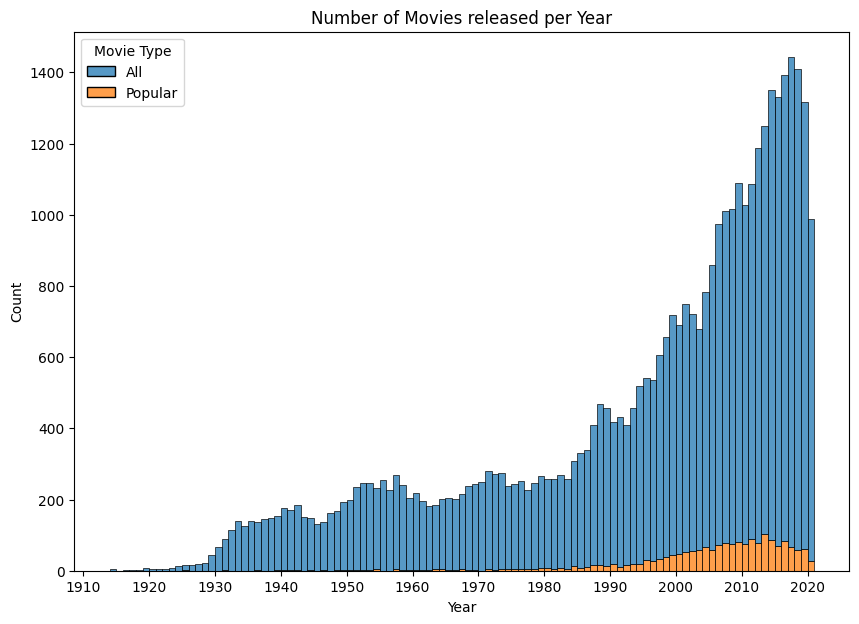

In [17]:
bins_year = df_movies_all["Year"].nunique()

plt.figure(figsize=(10, 7))
sns.histplot(data=df_movies_all, x="Year", bins=bins_year, hue="Movie Type", multiple="stack")
plt.locator_params(axis='x', nbins=20)
plt.title("Number of Movies released per Year")
plt.show()

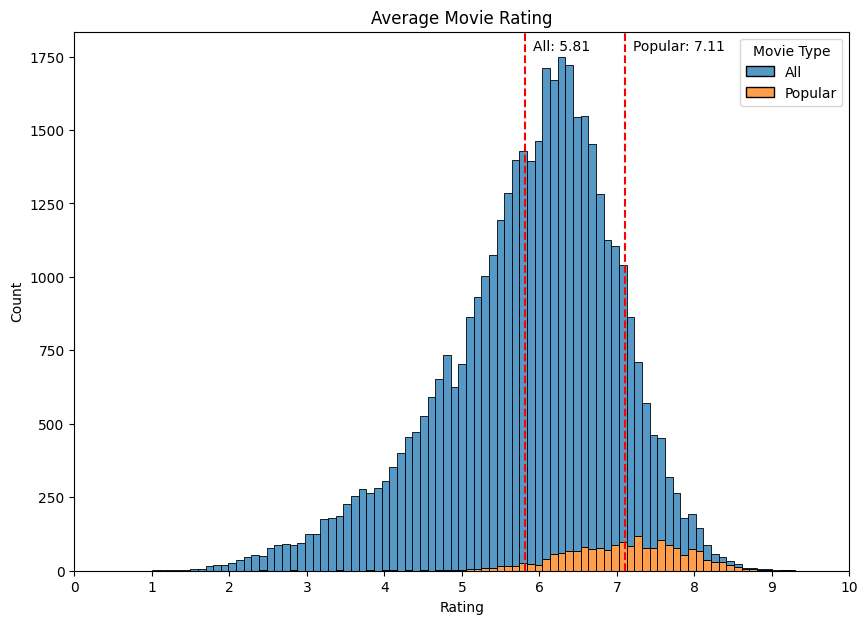

In [18]:
bins_rating = df_movies_all["Rating"].nunique()
flop_rating = df_movies_flop["Rating"].mean()
pop_rating = df_movies_pop["Rating"].mean()

plt.figure(figsize=(10, 7))
sns.histplot(data=df_movies_all, x="Rating", hue="Movie Type", multiple="stack", bins=bins_rating)
plt.axvline(flop_rating, color="red", linestyle="--")
plt.annotate(f"All: {flop_rating:.2f}", xy=(flop_rating + 0.1, 1770))
plt.axvline(pop_rating, color="red", linestyle="--")
plt.annotate(f"Popular: {pop_rating:.2f}", xy=(pop_rating + 0.1, 1770))
plt.locator_params(axis='x', nbins=10)
plt.xlim(0, 10)
plt.title("Average Movie Rating")
plt.show()

<a id='graphs'></a>
### 1.3. Graphs

In [19]:
random_seed = 42

In [20]:
def add_edge(g, u, v):
    if g.has_edge(u, v):
        g[u][v]["weight"] += 1
    else:
        g.add_edge(u, v, weight=1)

In [21]:
G = nx.Graph()
for _, row in tqdm(df_pop.iterrows()):
    add_edge(G, row["Actor"], row["Film"])

0it [00:00, ?it/s]

In [58]:
movies = df_movies_pop["Film"].tolist()
for node in G.nodes:
    if node in movies:
        G.nodes[node]["Rating"] = df_movies_pop[df_movies_pop["Film"] == node]["Rating"].values[0]

In [59]:
G.nodes["The Shawshank Redemption"]

{'Rating': 9.3}

In [22]:
actors = df_pop["Actor"].unique().tolist()
actors_sizes = df_pop["Actor"].value_counts().to_dict()
movies_sizes = df_pop["Film"].value_counts().to_dict()

In [44]:
def create_pos(G, actors, random_seed, safe=True):
    if not safe:
        return prepare_drawing(G.to_undirected(), actors, random_seed=random_seed)
    try:
        with open(os.path.join(path_to_data, "pos.json"), "r") as f:
            pos = json.load(f)
        actor_nodes = pd.read_csv(f"{path_to_data}/actor_nodes.csv", index_col=0)["0"].to_list()
        movie_nodes = pd.read_csv(f"{path_to_data}/movie_nodes.csv", index_col=0)["0"].to_list()
    except FileNotFoundError:
        print("Files not found, creating new positions and nodes...")
        pos, actor_nodes, movie_nodes = prepare_drawing(G.to_undirected(), actors, random_seed=random_seed)
        with open(f"{path_to_data}/pos.json", "w") as f:
            json.dump(
                {node: tuple(coords) for node, coords in pos.items()},
                f
            )
        pd.Series(actor_nodes).to_csv(os.path.join(path_to_data, "actor_nodes.csv"))
        pd.Series(movie_nodes).to_csv(os.path.join(path_to_data, "movie_nodes.csv"))
    return pos, actor_nodes, movie_nodes
pos, actor_nodes, movie_nodes = create_pos(G, actors, random_seed)

KeyboardInterrupt: 

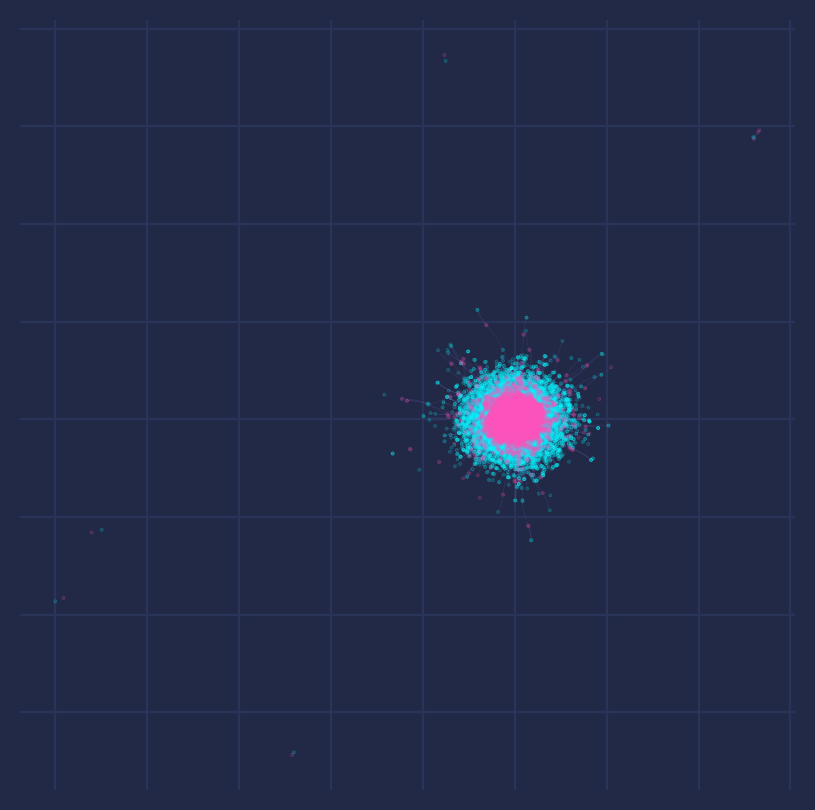

In [45]:
draw_graph_filtered(
    G,
    pos,
    figsize=(5, 5),
    dpi=500,
    nodes_list=[actor_nodes, movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    nodes_font_colors=["#CEECFF", "#FFD0FD"],
    node_size_reduction_factor=10,
    edge_linewidth_reduction_factor=5,
    add_labels=False,
    min_sizes=[1,1],
    min_sizes_labels=[20, 20],
    node_alpha=0.3,
    edge_alpha=0.15,
    dark_mode=True,
    curved_edges=True,
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=1
)

In [47]:
list(nx.isolates(G))

[]

In [48]:
nx.is_connected(G)

False

As we could observe in the visualisations of the graph, it is not strongly connected. To get rid of the isolated groups we create the giant connected component (GCC) which contains largest component, the maximal connected induced subgraph.

In [49]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

In [50]:
nx.is_connected(G0)

True

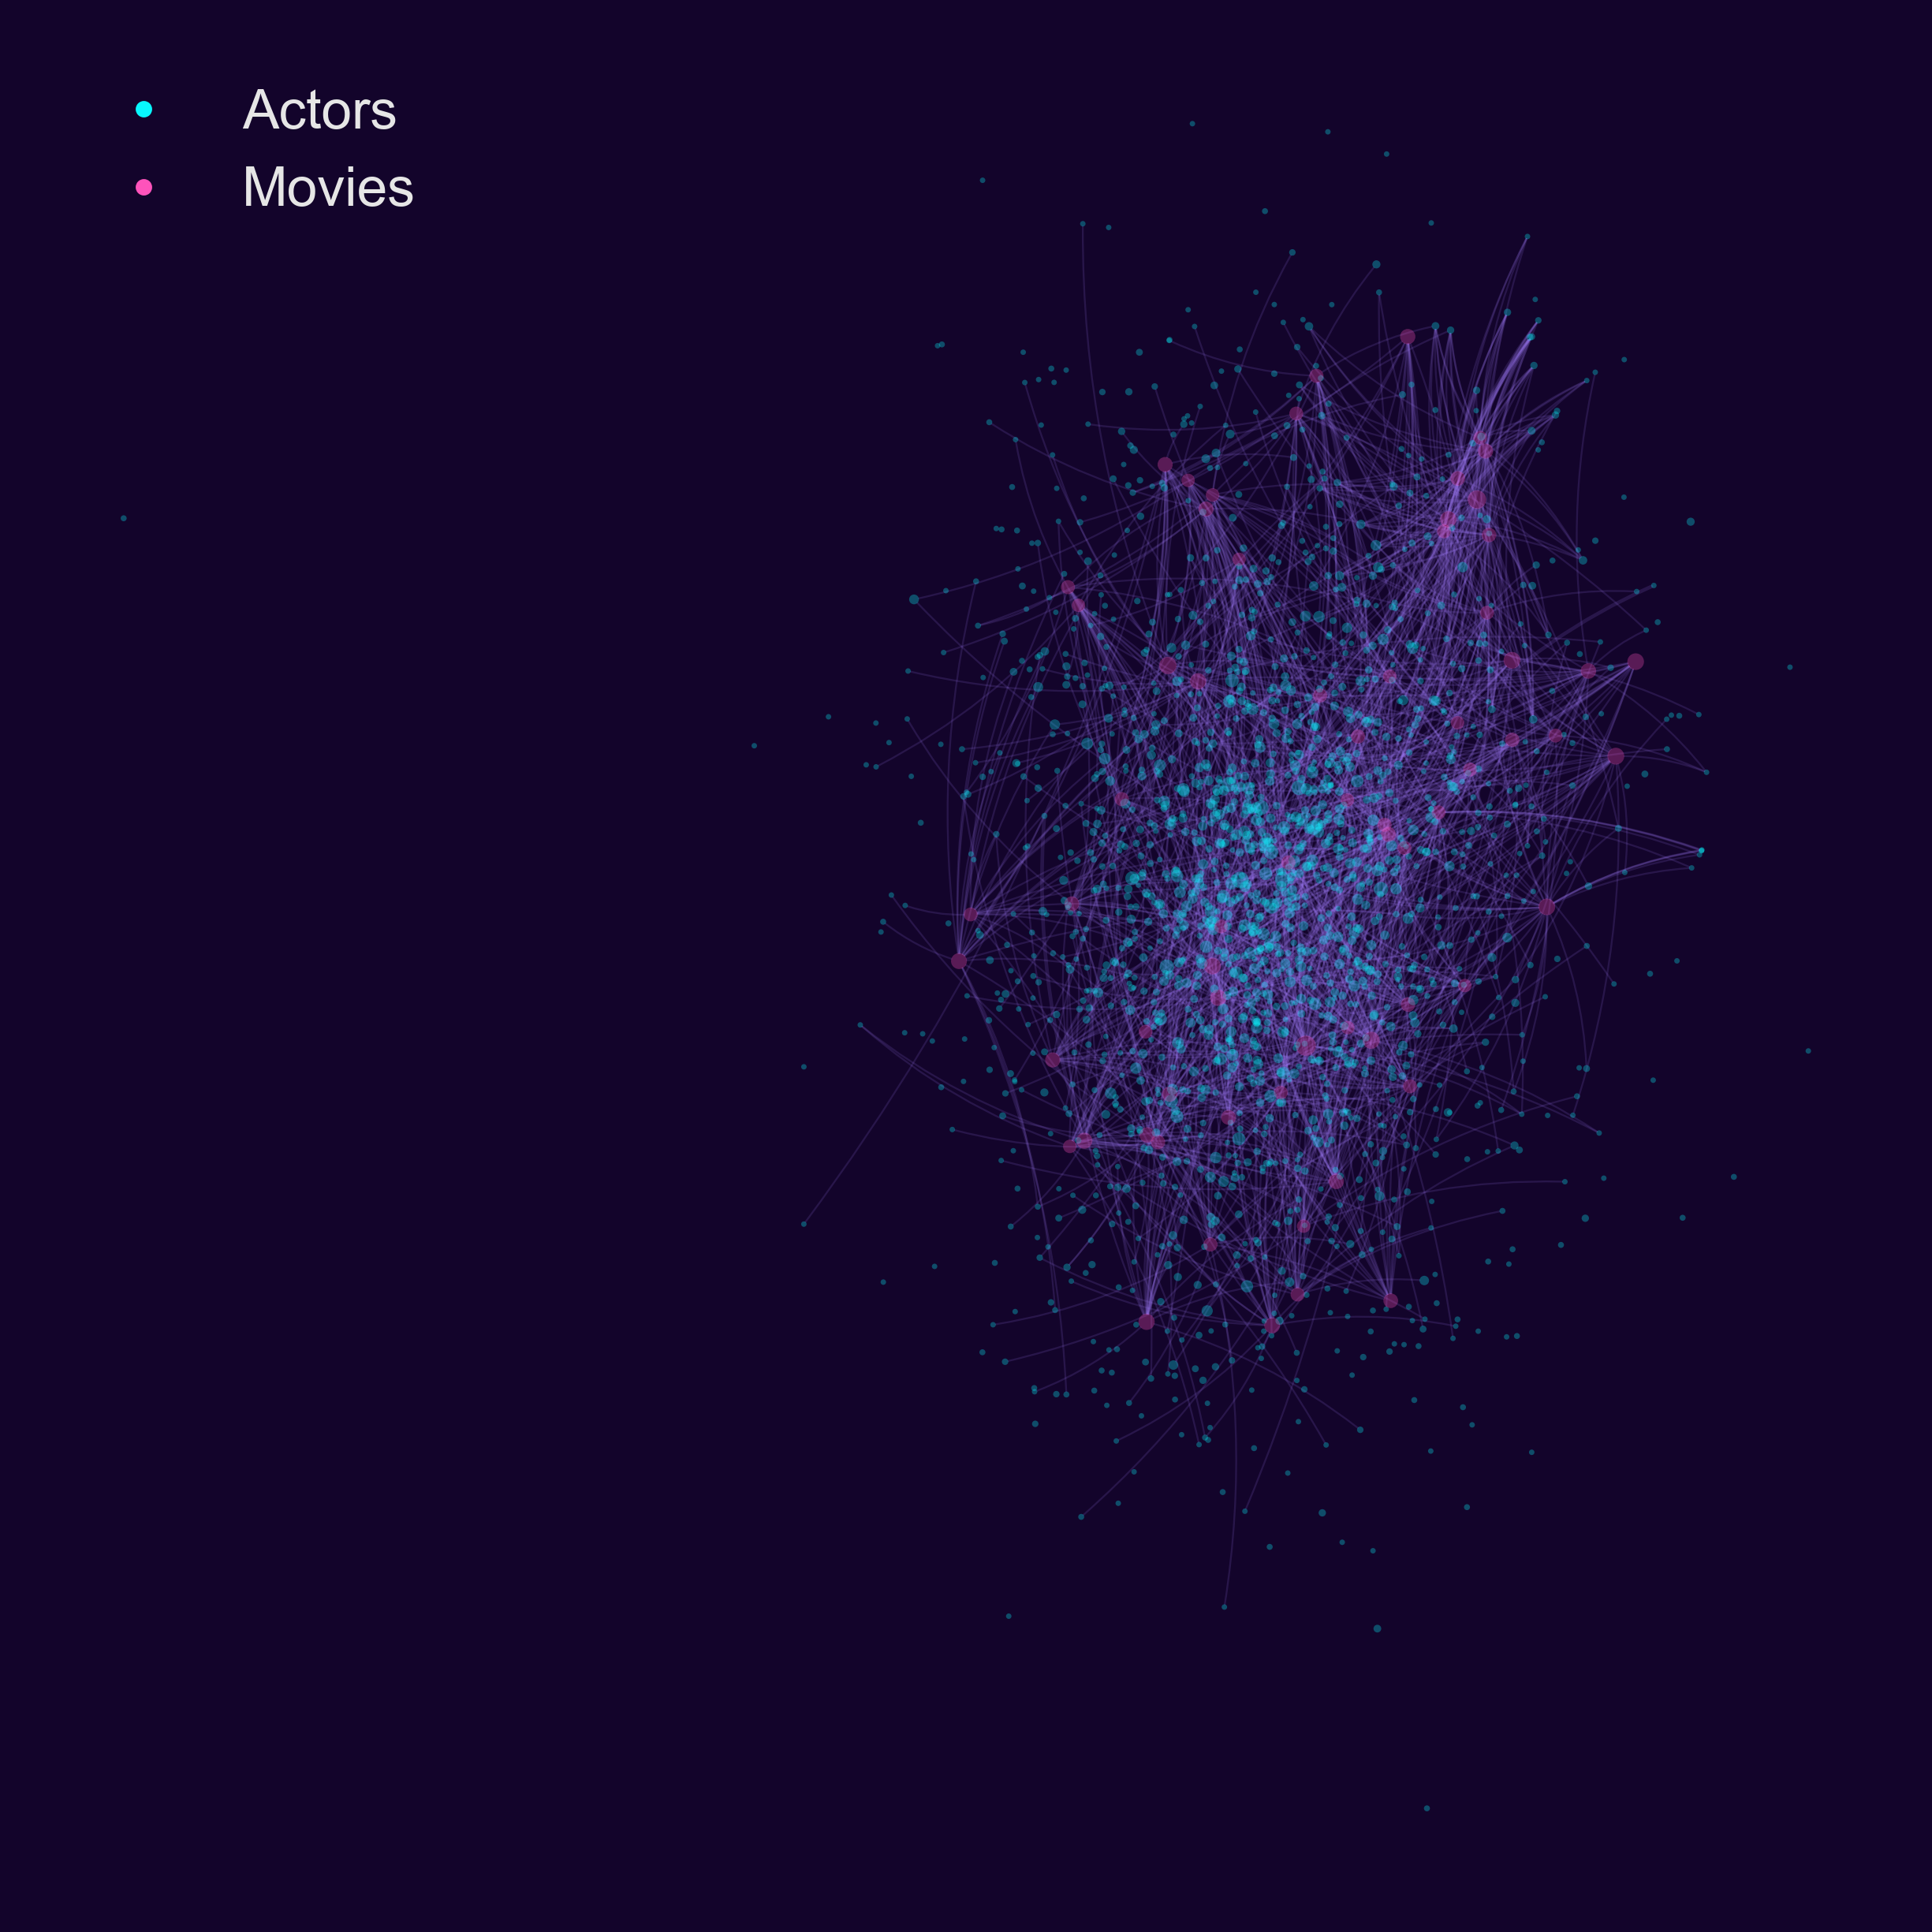

In [56]:
pos, actor_nodes, movie_nodes = create_pos(G0, actors, random_seed, safe=False)
draw_graph_filtered(
    G0,
    pos,
    figsize=(5, 5),
    dpi=500,
    nodes_list=[actor_nodes, movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    nodes_font_colors=["#CEECFF", "#FFD0FD"],
    node_size_reduction_factor=5,
    edge_linewidth_reduction_factor=3,
    add_labels=False,
    min_sizes=[5,20], # Minimum size of nodes to be displayed
    min_sizes_labels=[800, 1000], # Minimum size of nodes to display labels
    node_alpha=0.3,
    edge_alpha=0.15,
    dark_mode=True,
    curved_edges=True,
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=2
)

In [51]:
sub_G = nx.ego_graph(G0, "Forrest Gump")
sub_pos, sub_actor_nodes, sub_movie_nodes = create_pos(sub_G, actors, random_seed, safe=False)

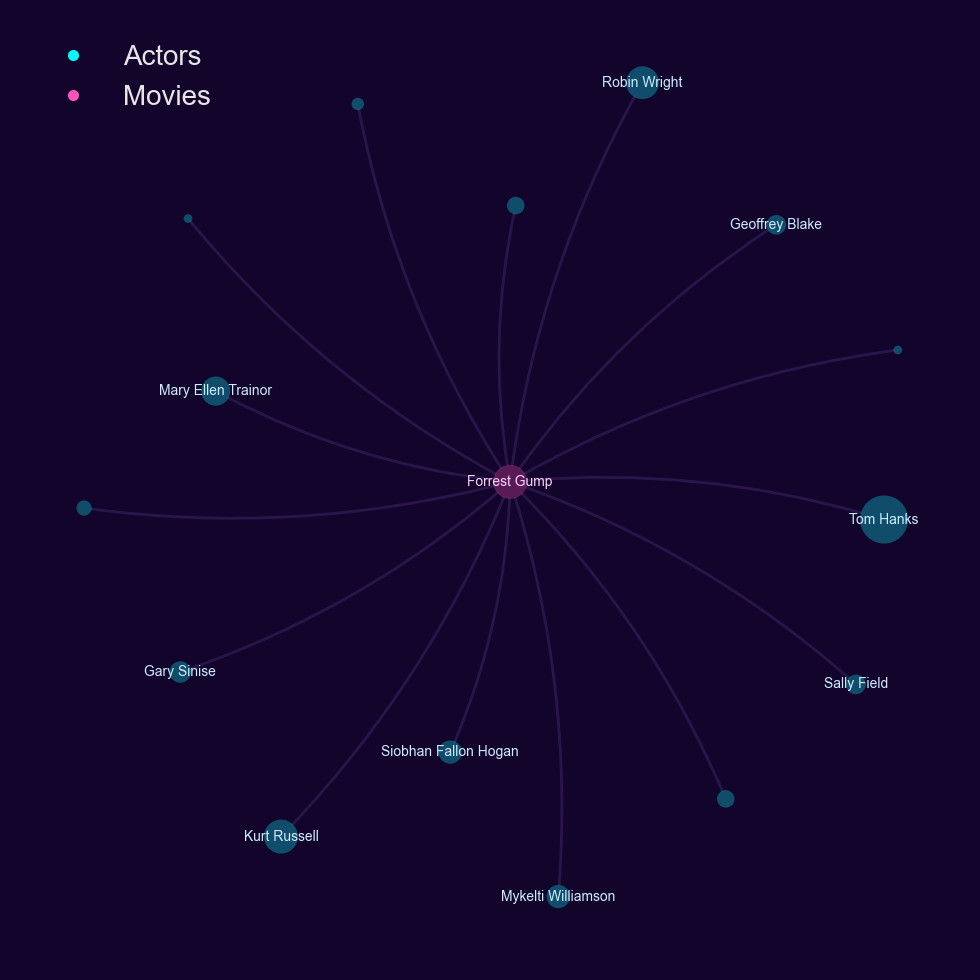

In [52]:
draw_graph_filtered(
    sub_G,
    sub_pos,
    figsize=(5, 5),
    dpi=200,
    nodes_list=[sub_actor_nodes, sub_movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    nodes_font_colors=["#CEECFF", "#FFD0FD"],
    node_size_reduction_factor=0.1,
    edge_linewidth_reduction_factor=1,
    add_labels=True,
    min_sizes=[1,1],
    min_sizes_labels=[5, 10],
    node_alpha=0.3,
    edge_alpha=0.15,
    font_size=5,
    dark_mode=True,
    curved_edges=True,
    legend_labels={"Actors": "C0", "Movies": "C1"},
    legend_loc="upper left",
    legend_size=3
)

In [53]:
def graph_metrics(G):
    results = dict()
    results["density"] = nx.density(G)
    results["diameter"] = nx.diameter(G)
    results["avg_shortest_path_length"] = nx.average_shortest_path_length(G)
    results["local_efficiency"] = nx.local_efficiency(G)
    results["global_efficiency"] = nx.global_efficiency(G)
    results["transitivity"] = nx.transitivity(G)
    results["avg_clustering"] = nx.average_clustering(G)
    results["correlation_coefficient"] = nx.degree_pearson_correlation_coefficient(G)
    return results

In [54]:
G_nodes = G0.number_of_nodes()
G_edges = G0.number_of_edges()
G_nodes, G_edges

(8540, 26088)

In [57]:
random_G = nx.gnm_random_graph(G_nodes, G_edges, seed=random_seed)
metrics_df = pd.DataFrame([graph_metrics(G0), graph_metrics(random_G)], index=["IMDB", "Random"])

KeyboardInterrupt: 

In [ ]:
metrics_df

---
<a id='exp'></a>

## 2. Experiments

<a id='noderoles'></a>
### 2.1. Node-Roles


In [ ]:
node_strength = dict(sub_G.degree(weight="weight"))
betweenness = nx.betweenness_centrality(sub_G)
closeness = nx.closeness_centrality(sub_G)

index_cols = ["node_strength", "betweenness", "closeness"]
df_analysis = pd.DataFrame([node_strength, betweenness, closeness], index=index_cols).T
for col in index_cols:
    df_analysis[f"{col}_rank"] = df_analysis[col].rank(ascending=False)

In [ ]:
df_analysis.nlargest(10, "node_strength")

In [ ]:
def rawComm(G, candidate):
    neighbors = [n for n in G.neighbors(candidate)]
    return sum([1 / G.degree(neighbor) for neighbor in neighbors])

In [ ]:
degree = [sub_G.degree(v) for v in actors]
rawcomm = [rawComm(sub_G, v) for v in actors]

In [ ]:
mean_degree = sum(degree) / len(degree)
mean_rawcomm = sum(rawcomm) / len(rawcomm)

plt.scatter(rawcomm, degree, s=1)
for i, txt in enumerate(actors):
    plt.annotate(txt, (rawcomm[i], degree[i]))
plt.axhline(mean_degree)
plt.axvline(mean_rawcomm)
plt.xlabel("rawComm")
plt.ylabel("Degree")
plt.show()


<a id='comdis'></a>

### 2.2. Community-Discovery


#### 2.2.1 Louvain Community Detection

In [ ]:
def create_node_colors(communities):
    return {node: f"C{idx}" for idx, area in enumerate(communities) for node in area}

In [ ]:
communities_louvain = nx_comm.louvain_communities(sub_G, seed=random_seed)
node_color_dict_comm = create_node_colors(communities_louvain)

In [ ]:
draw_graph_filtered(
    G,
    pos,
    figsize=(5, 5),
    dpi=200,
    nodes_list=[actor_nodes, movie_nodes],
    nodes_sizes_list=[actors_sizes, movies_sizes],
    nodes_font_colors=["#CEECFF", "#FFD0FD"],
    node_size_reduction_factor=0.1,
    edge_linewidth_reduction_factor=1,
    add_labels=True,
    min_sizes=[20,20],
    min_sizes_labels=[80, 100],
    node_alpha=0.3,
    edge_alpha=0.15,
    dark_mode=True,
    curved_edges=True,
    node_colors=node_color_dict_comm,
)

#### 2.2.2. Lukes Algorithm

In [ ]:
communities_luke = nx_comm.lukes_partitioning(sub_G, seed=random_seed)
node_color_dict_luke = create_node_colors(communities_luke)

---
<a id='results'></a>

## 3. Results


---
<a id='ref'></a>

## References

<p> [1] https://www.kaggle.com/datasets/darinhawley/imdb-films-by-actor-for-10k-actors



<p> [2] Renjith, Shini, A. Sreekumar, and M. Jathavedan. 2018. Evaluation of Partitioning Clustering Algorithms for Processing Social Media Data in Tourism Domain. In 2018 IEEE Recent Advances in Intelligent Computational Systems (RAICS), 127-131. IEEE.
<p> [3] https://www.kaggle.com/code/johnmantios/travel-review-ratings-dataset#Clustering
<p> [4] https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering
<p> [5] Ankerst, Mihael, Markus M. Breunig, Hans-Peter Kriegel, and Jörg Sander. “OPTICS: ordering points to identify the clustering structure.” ACM SIGMOD Record 28, no. 2 (1999): 49-60.